<a href="https://colab.research.google.com/github/zzh8829/yolov3-tf2/blob/master/colab_gpu.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# YoloV3 TF2 GPU Colab Notebook

##### 1.  Clone and install dependencies 

**IMPORTANT**: Restart following the instruction

### Troubleshooting

- 如果检测不到GPU，通常是因为缺少动态链接库，ref：https://github.com/tensorflow/tensorflow/issues/35968#issuecomment-588762962

- 解决办法：安装对应开发和运行时库

```shell
# install nvidia key
wget http://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64/7fa2af80.pub
sudo apt-key add 7fa2af80.pub

# add repo's
sudo bash -c 'echo "deb https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64/ /" > /etc/apt/sources.list.d/cuda.list'
sudo bash -c 'echo "deb https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64 /" > /etc/apt/sources.list.d/machine-learning.list'

sudo apt-get update

# Install development and runtime libraries (~4GB)
sudo apt-get install --no-install-recommends \
    cuda-10-1 \
    libcudnn7=7.6.4.38-1+cuda10.1  \
    libcudnn7-dev=7.6.4.38-1+cuda10.1


# Install TensorRT. Requires that libcudnn7 is installed above.
sudo apt-get install -y --no-install-recommends libnvinfer6=6.0.1-1+cuda10.1 \
    libnvinfer-dev=6.0.1-1+cuda10.1 \
    libnvinfer-plugin6=6.0.1-1+cuda10.1
```

In [1]:
!git clone https://github.com/zzh8829/yolov3-tf2
#%cd yolov3-tf2/
!pip install -r requirements-gpu.txt

Obtaining file:///mnt/batch/tasks/shared/LS_root/mounts/clusters/gpu-dev0/code/Users/aml/course/yolov3-tf2 (from -r requirements-gpu.txt (line 6))
     |████████████████████████████████| 421.8MB 186kB/s  eta 0:00:01    |███████                         | 92.6MB 62.9MB/s eta 0:00:06/s eta 0:00:04     |████████████████████████████▋   | 377.2MB 72.4MB/s eta 0:00:01
     |████████████████████████████████| 28.7MB 19.8MB/s eta 0:00:01
     |████████████████████████████████| 3.9MB 58.7MB/s eta 0:00:01
     |████████████████████████████████| 450kB 60.3MB/s eta 0:00:01
  Created wheel for gast: filename=gast-0.2.2-cp36-none-any.whl size=7540 sha256=1ee2c785d517e5424e150b76839a1418fb9a3277fe3e380a3622c33ddae9325b
  Stored in directory: /home/azureuser/.cache/pip/wheels/5c/2e/7e/a1d4d4fcebe6c381f378ce7743a3ced3699feb89bcfbdadadd
Successfully built gast
  Found existing installation: tensorboard 2.2.1
    Uninstalling tensorboard-2.2.1:
      Successfully uninstalled tensorboard-2.2.1
  Found exist

##### 2.  Check Tensorflow2 version

In [1]:
#%cd yolov3-tf2/
!ls

import tensorflow as tf
tf.__version__

checkpoints	 data		  README.md		train.py
colab_gpu.ipynb  detect.py	  requirements-gpu.txt	yolov3_tf2
conda-cpu.yml	 detect_video.py  requirements.txt	yolov3_tf2.egg-info
conda-gpu.yml	 docs		  setup.py
convert.py	 LICENSE	  tools


'2.1.0'

In [2]:
import tensorflow as tf
print(tf.test.is_gpu_available())
gpus = tf.config.list_physical_devices(device_type='GPU')
print(gpus)

Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.
True
[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


##### 3.  Convert Pretrained Darknet Weight

In [4]:
#!wget https://pjreddie.com/media/files/yolov3.weights -O data/yolov3.weights
!python convert.py

2020-05-18 16:33:34.322747: W tensorflow/stream_executor/platform/default/dso_loader.cc:55] Could not load dynamic library 'libnvinfer.so.6'; dlerror: /lib/x86_64-linux-gnu/libm.so.6: version `GLIBC_2.27' not found (required by /usr/lib/x86_64-linux-gnu/libnvinfer.so.6)
2020-05-18 16:33:34.322958: W tensorflow/stream_executor/platform/default/dso_loader.cc:55] Could not load dynamic library 'libnvinfer_plugin.so.6'; dlerror: libnvrtc.so.10.1: cannot open shared object file: No such file or directory
2020-05-18 16:33:34.322981: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:30] Cannot dlopen some TensorRT libraries. If you would like to use Nvidia GPU with TensorRT, please make sure the missing libraries mentioned above are installed properly.
2020-05-18 16:33:35.350068: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcuda.so.1
2020-05-18 16:33:35.353693: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1555] Found device 0 w

##### 4. Initialize Detector

In [5]:
import sys
from absl import app, logging, flags
from absl.flags import FLAGS
import time
import cv2
import numpy as np
import tensorflow as tf
from yolov3_tf2.models import (
    YoloV3, YoloV3Tiny
)
from yolov3_tf2.dataset import transform_images, load_tfrecord_dataset
from yolov3_tf2.utils import draw_outputs

flags.DEFINE_string('classes', './data/coco.names', 'path to classes file')
flags.DEFINE_string('weights', './checkpoints/yolov3.tf',
                    'path to weights file')
flags.DEFINE_boolean('tiny', False, 'yolov3 or yolov3-tiny')
flags.DEFINE_integer('size', 416, 'resize images to')
flags.DEFINE_string('image', './data/girl.png', 'path to input image')
flags.DEFINE_string('tfrecord', None, 'tfrecord instead of image')
flags.DEFINE_string('output', './output.jpg', 'path to output image')
flags.DEFINE_integer('num_classes', 80, 'number of classes in the model')

app._run_init(['yolov3'], app.parse_flags_with_usage)

physical_devices = tf.config.experimental.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(physical_devices[0], True)

##### 4. Detect Image

I0518 17:41:32.640362 139937594783488 <ipython-input-6-b1b93607b63e>:9] weights loaded
I0518 17:41:32.753400 139937594783488 <ipython-input-6-b1b93607b63e>:12] classes loaded
I0518 17:41:34.640139 139937594783488 <ipython-input-6-b1b93607b63e>:23] time: 1.705538034439087
I0518 17:41:34.640980 139937594783488 <ipython-input-6-b1b93607b63e>:25] detections:
I0518 17:41:34.645318 139937594783488 <ipython-input-6-b1b93607b63e>:29] 	cup, 0.9980731010437012, [0.14266218 0.52777606 0.27184254 0.65748256]
I0518 17:41:34.647459 139937594783488 <ipython-input-6-b1b93607b63e>:29] 	person, 0.9976975321769714, [0.28982922 0.0985465  0.95846474 0.9202168 ]
I0518 17:41:34.649693 139937594783488 <ipython-input-6-b1b93607b63e>:29] 	laptop, 0.9846140146255493, [0.         0.39493692 0.5229728  0.7962775 ]
I0518 17:41:34.651904 139937594783488 <ipython-input-6-b1b93607b63e>:29] 	apple, 0.9082661271095276, [0.13114463 0.77143586 0.22893356 0.90729535]
I0518 17:41:34.654116 139937594783488 <ipython-input-6-

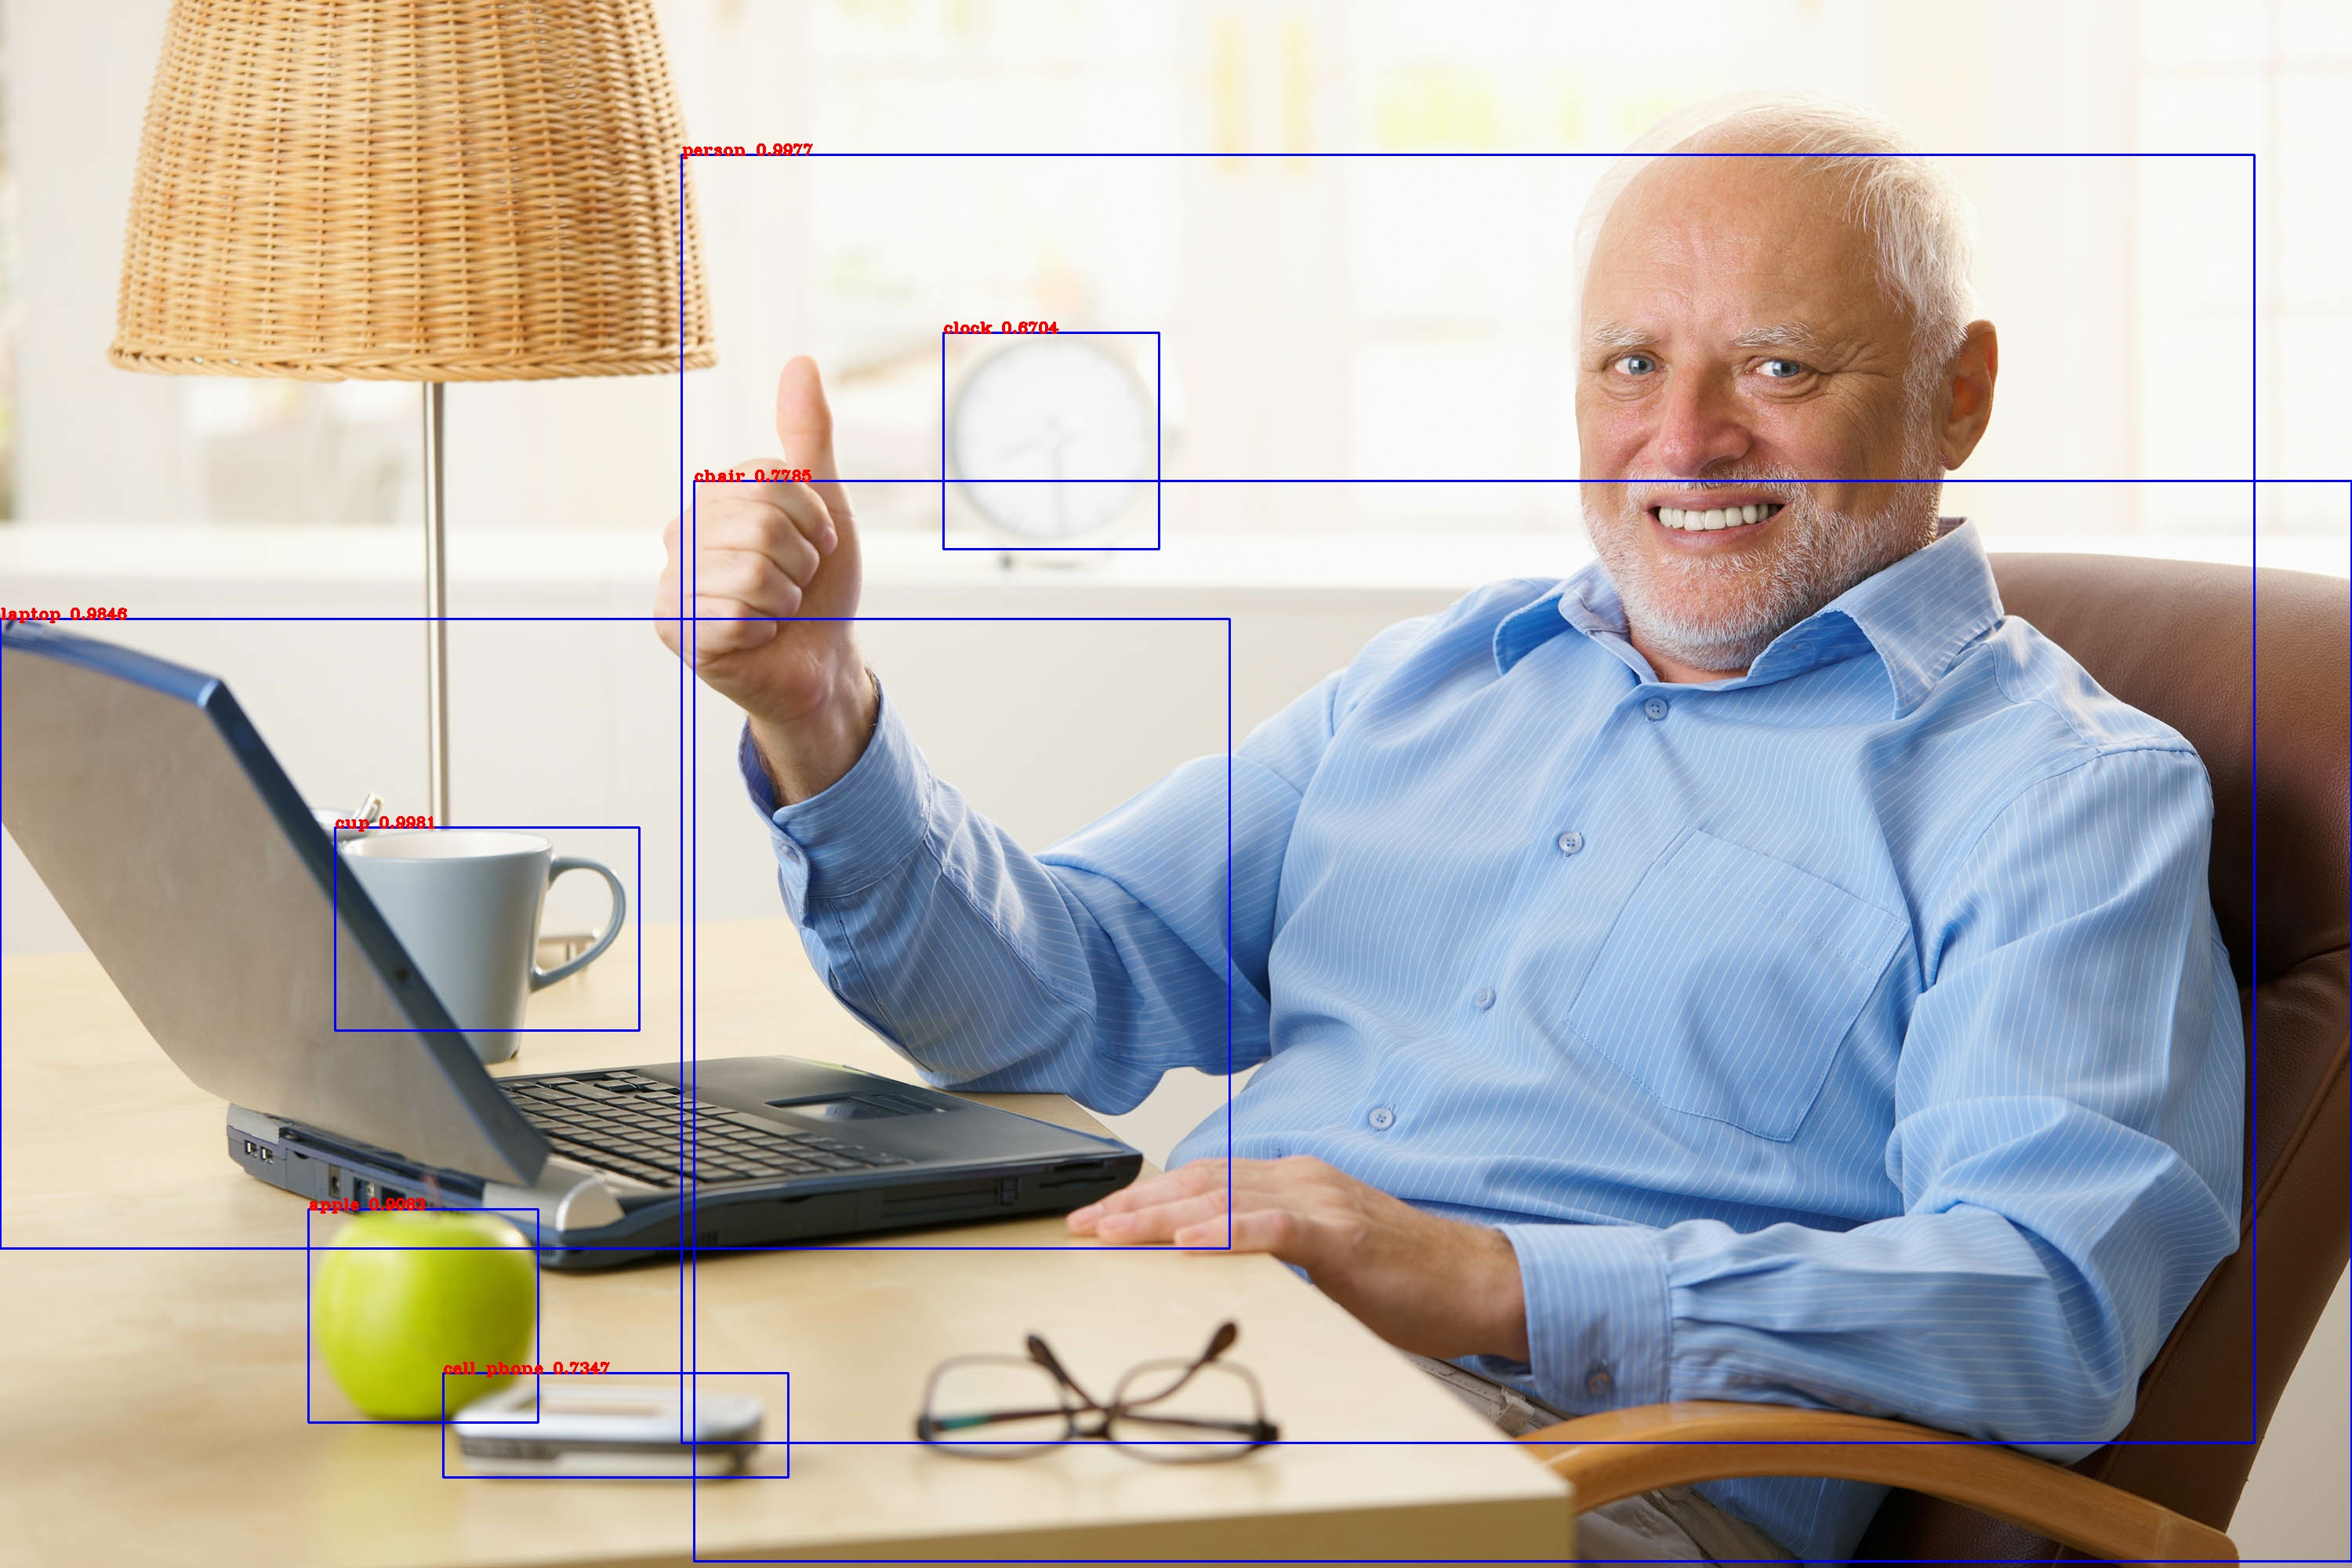

In [6]:
FLAGS.image = 'data/meme.jpg'

if FLAGS.tiny:
    yolo = YoloV3Tiny(classes=FLAGS.num_classes)
else:
    yolo = YoloV3(classes=FLAGS.num_classes)
      
yolo.load_weights(FLAGS.weights).expect_partial()
logging.info('weights loaded')

class_names = [c.strip() for c in open(FLAGS.classes).readlines()]
logging.info('classes loaded')

img_raw = tf.image.decode_image(
    open(FLAGS.image, 'rb').read(), channels=3)

img = tf.expand_dims(img_raw, 0)
img = transform_images(img, FLAGS.size)

t1 = time.time()
boxes, scores, classes, nums = yolo(img)
t2 = time.time()
logging.info('time: {}'.format(t2 - t1))

logging.info('detections:')
for i in range(nums[0]):
    logging.info('\t{}, {}, {}'.format(class_names[int(classes[0][i])],
                                        np.array(scores[0][i]),
                                        np.array(boxes[0][i])))

img = cv2.cvtColor(img_raw.numpy(), cv2.COLOR_RGB2BGR)
img = draw_outputs(img, (boxes, scores, classes, nums), class_names)

from IPython.display import Image, display
display(Image(data=bytes(cv2.imencode('.jpg', img)[1]), width=800))

##### 5. Training New Dataset

In [9]:
#!wget http://host.robots.ox.ac.uk/pascal/VOC/voc2009/VOCtrainval_11-May-2009.tar -O ./data/voc2009_raw.tar
#!mkdir -p ./data/voc2009_raw
!tar -xf ./data/voc2009_raw.tar -C ./data/voc2009_raw

In [10]:
!python tools/voc2012.py \
  --data_dir './data/voc2009_raw/VOCdevkit/VOC2009' \
  --split train \
  --output_file ./data/voc_train.tfrecord

!python tools/voc2012.py \
  --data_dir './data/voc2009_raw/VOCdevkit/VOC2009' \
  --split val \
  --output_file ./data/voc_val.tfrecord

2020-05-18 17:01:18.949999: W tensorflow/stream_executor/platform/default/dso_loader.cc:55] Could not load dynamic library 'libnvinfer.so.6'; dlerror: /lib/x86_64-linux-gnu/libm.so.6: version `GLIBC_2.27' not found (required by /usr/lib/x86_64-linux-gnu/libnvinfer.so.6)
2020-05-18 17:01:18.950202: W tensorflow/stream_executor/platform/default/dso_loader.cc:55] Could not load dynamic library 'libnvinfer_plugin.so.6'; dlerror: libnvrtc.so.10.1: cannot open shared object file: No such file or directory
2020-05-18 17:01:18.950226: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:30] Cannot dlopen some TensorRT libraries. If you would like to use Nvidia GPU with TensorRT, please make sure the missing libraries mentioned above are installed properly.
I0518 17:01:20.007077 140226230265600 voc2012.py:92] Class mapping loaded: {'aeroplane': 0, 'bicycle': 1, 'bird': 2, 'boat': 3, 'bottle': 4, 'bus': 5, 'car': 6, 'cat': 7, 'chair': 8, 'cow': 9, 'diningtable': 10, 'dog': 11, 'horse': 12, 'motor

In [1]:
!python tools/visualize_dataset.py --dataset ./data/voc_train.tfrecord --classes=./data/voc2012.names

2020-05-18 17:18:27.071574: W tensorflow/stream_executor/platform/default/dso_loader.cc:55] Could not load dynamic library 'libnvinfer.so.6'; dlerror: /lib/x86_64-linux-gnu/libm.so.6: version `GLIBC_2.27' not found (required by /usr/lib/x86_64-linux-gnu/libnvinfer.so.6)
2020-05-18 17:18:27.071820: W tensorflow/stream_executor/platform/default/dso_loader.cc:55] Could not load dynamic library 'libnvinfer_plugin.so.6'; dlerror: libnvrtc.so.10.1: cannot open shared object file: No such file or directory
2020-05-18 17:18:27.071844: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:30] Cannot dlopen some TensorRT libraries. If you would like to use Nvidia GPU with TensorRT, please make sure the missing libraries mentioned above are installed properly.
I0518 17:18:28.390630 139654845208320 visualize_dataset.py:22] classes loaded
2020-05-18 17:18:28.391783: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcuda.so.1
2020-05-18 17:18:28.396

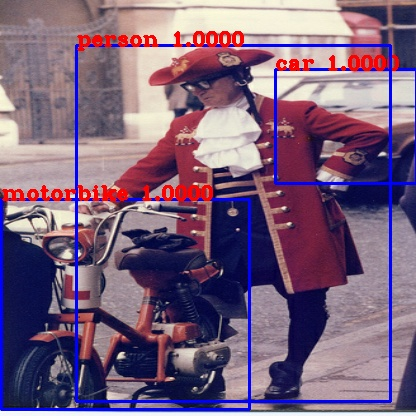

In [2]:
from IPython.display import Image
Image(filename='./output.jpg')

In [3]:
!python train.py \
	--dataset ./data/voc_train.tfrecord \
	--val_dataset ./data/voc_val.tfrecord \
	--classes ./data/voc2012.names \
	--num_classes 20 \
	--mode fit --transfer darknet \
	--batch_size 16 \
	--epochs 3 \
	--weights ./checkpoints/yolov3.tf \
	--weights_num_classes 80 

2020-05-18 17:18:49.097680: W tensorflow/stream_executor/platform/default/dso_loader.cc:55] Could not load dynamic library 'libnvinfer.so.6'; dlerror: /lib/x86_64-linux-gnu/libm.so.6: version `GLIBC_2.27' not found (required by /usr/lib/x86_64-linux-gnu/libnvinfer.so.6)
2020-05-18 17:18:49.097895: W tensorflow/stream_executor/platform/default/dso_loader.cc:55] Could not load dynamic library 'libnvinfer_plugin.so.6'; dlerror: libnvrtc.so.10.1: cannot open shared object file: No such file or directory
2020-05-18 17:18:49.097918: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:30] Cannot dlopen some TensorRT libraries. If you would like to use Nvidia GPU with TensorRT, please make sure the missing libraries mentioned above are installed properly.
2020-05-18 17:18:50.290323: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcuda.so.1
2020-05-18 17:18:50.294325: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1555] Found device 0 w

##### 6. Detect using new weights

I0518 18:03:38.549485 139937594783488 <ipython-input-23-a52773b1fc3c>:16] weights loaded
I0518 18:03:38.636643 139937594783488 <ipython-input-23-a52773b1fc3c>:19] classes loaded
I0518 18:03:39.053092 139937594783488 <ipython-input-23-a52773b1fc3c>:30] time: 0.21448493003845215
I0518 18:03:39.053917 139937594783488 <ipython-input-23-a52773b1fc3c>:32] detections:
I0518 18:03:39.056623 139937594783488 <ipython-input-23-a52773b1fc3c>:36] 	cat, 0.22725488245487213, [0.5812015  0.30390084 0.9954038  0.7250453 ]


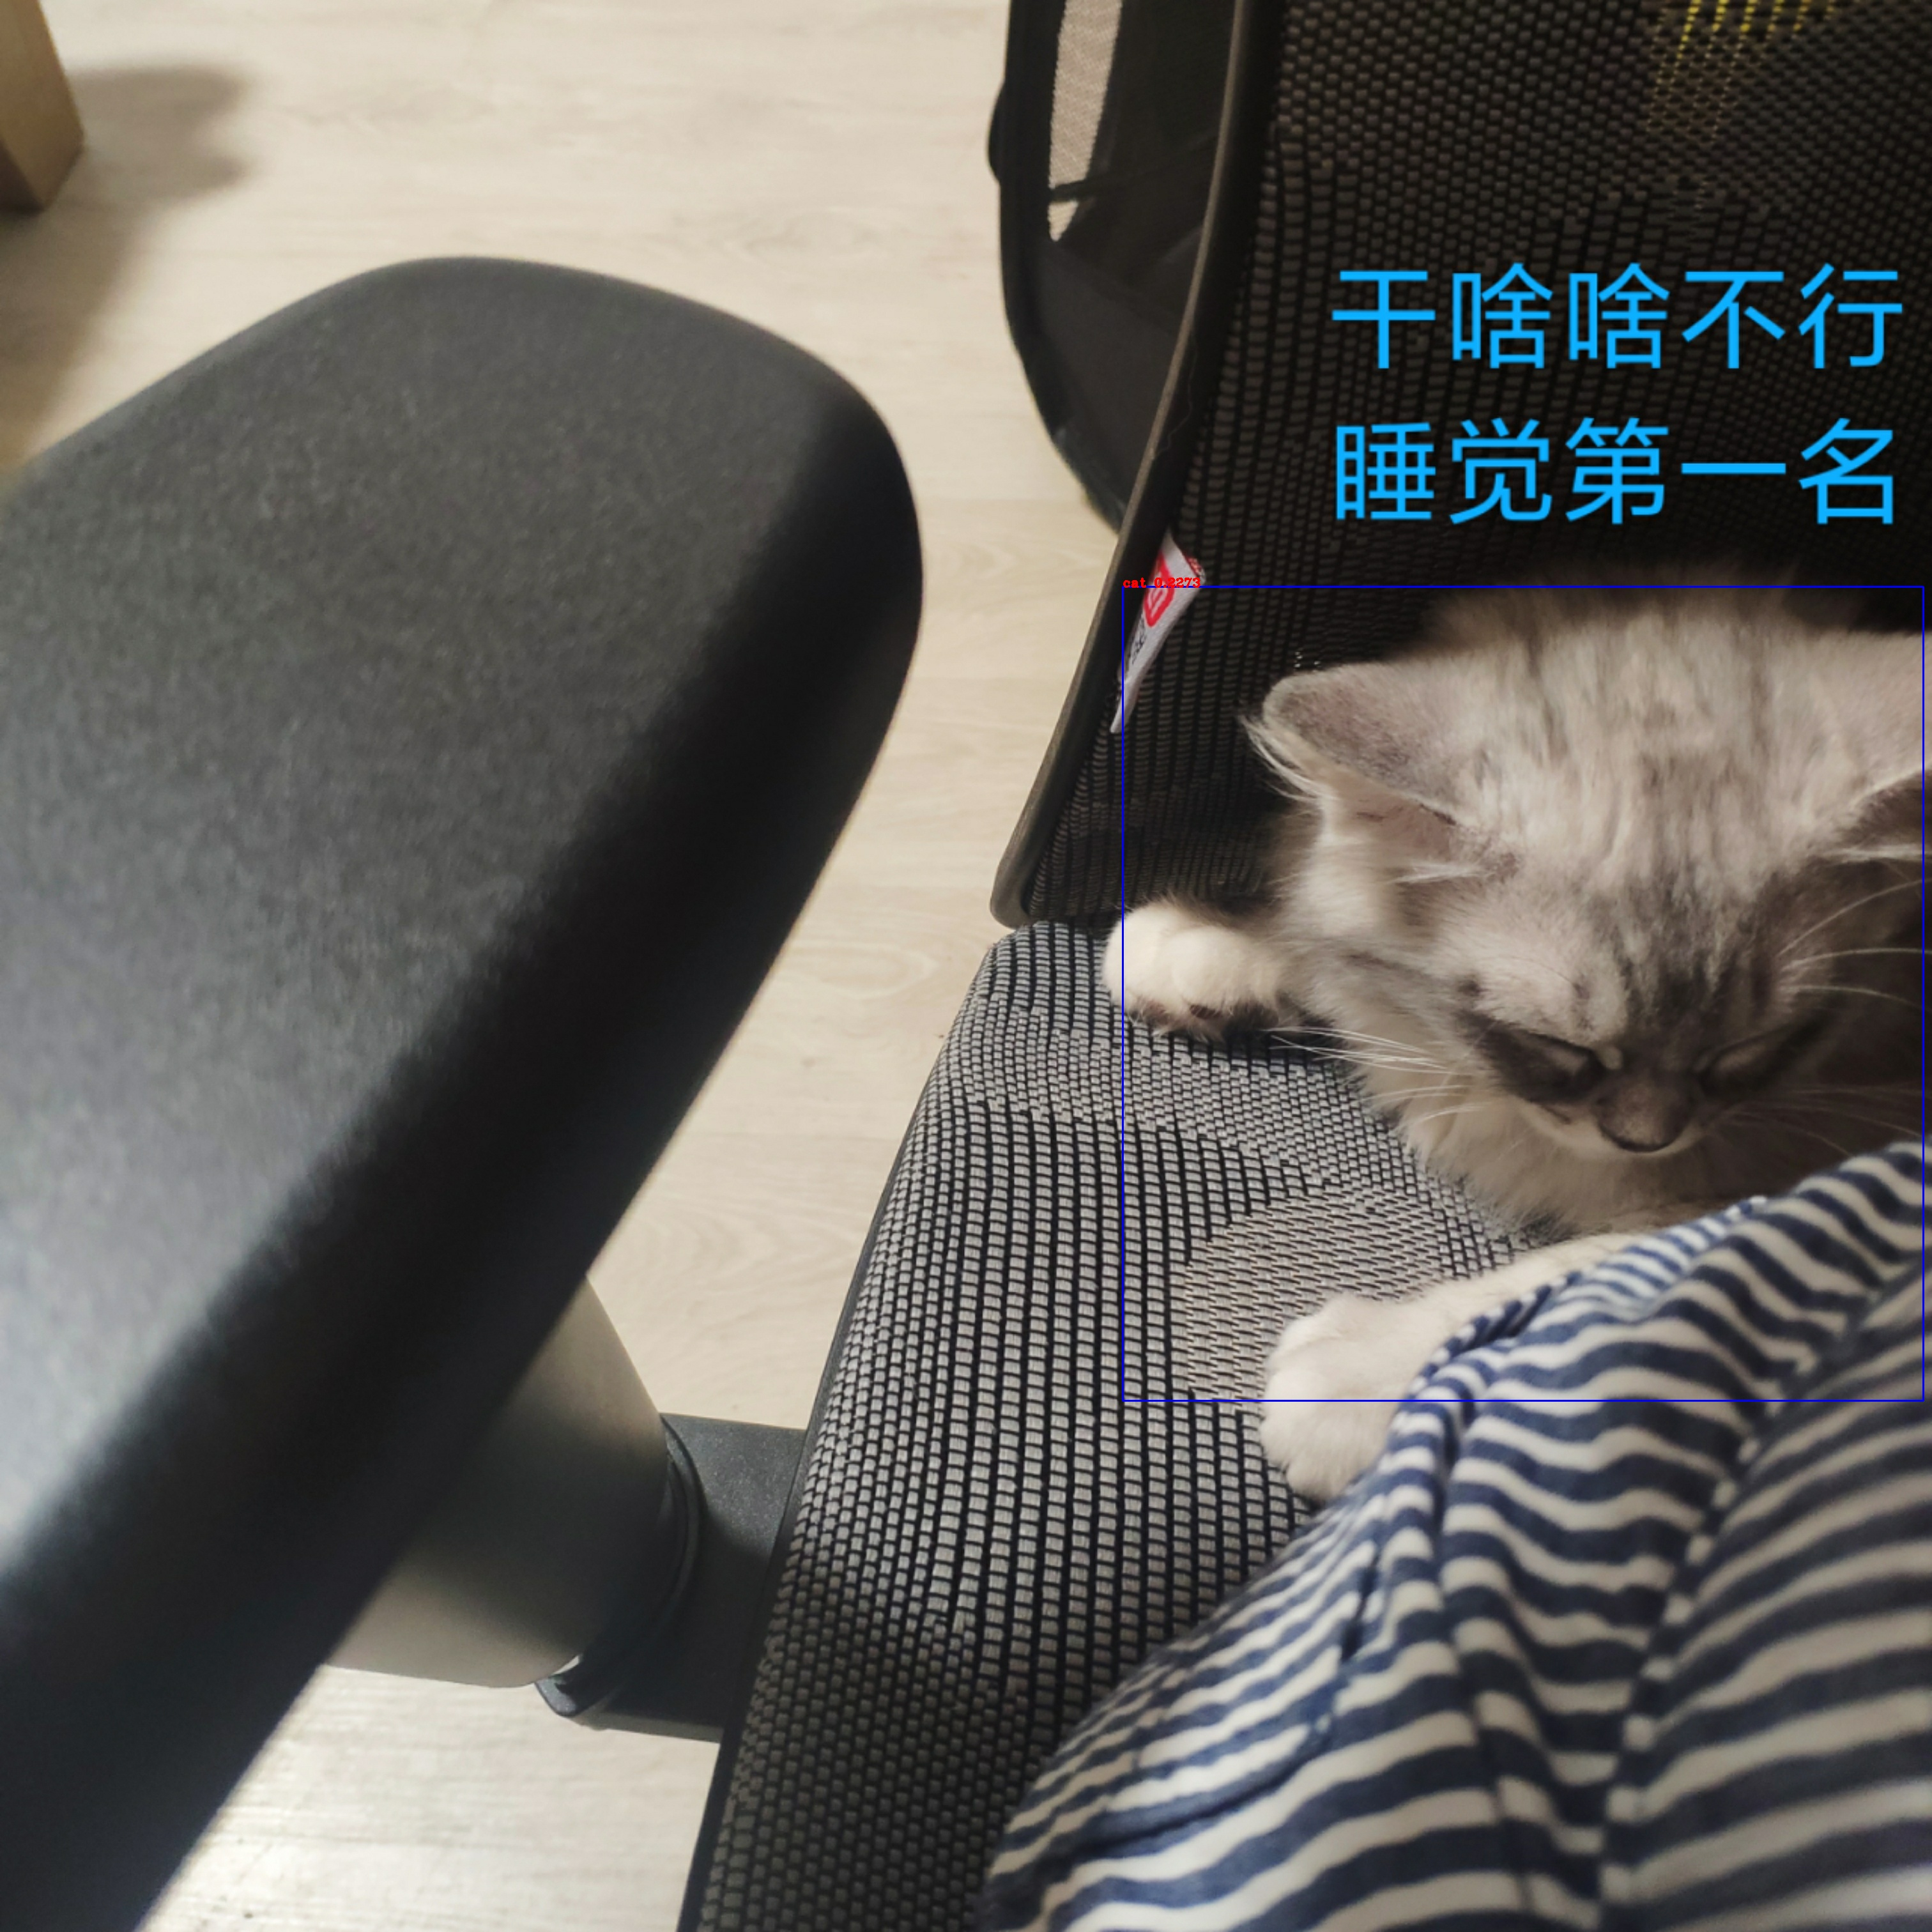

In [23]:
FLAGS.num_classes = 20
FLAGS.classes = 'data/voc2012.names'
FLAGS.weights = 'checkpoints/yolov3_train_3.tf'
FLAGS.image = 'data/cat1.jpeg'

# Lower threshold due to insufficient training
FLAGS.yolo_iou_threshold = 0.2
FLAGS.yolo_score_threshold = 0.2

if FLAGS.tiny:
    yolo = YoloV3Tiny(classes=FLAGS.num_classes)
else:
    yolo = YoloV3(classes=FLAGS.num_classes)

yolo.load_weights(FLAGS.weights).expect_partial()
logging.info('weights loaded')

class_names = [c.strip() for c in open(FLAGS.classes).readlines()]
logging.info('classes loaded')

img_raw = tf.image.decode_image(
    open(FLAGS.image, 'rb').read(), channels=3)

img = tf.expand_dims(img_raw, 0)
img = transform_images(img, FLAGS.size)

t1 = time.time()
boxes, scores, classes, nums = yolo(img)
t2 = time.time()
logging.info('time: {}'.format(t2 - t1))

logging.info('detections:')
for i in range(nums[0]):
    logging.info('\t{}, {}, {}'.format(class_names[int(classes[0][i])],
                                        np.array(scores[0][i]),
                                        np.array(boxes[0][i])))

img = cv2.cvtColor(img_raw.numpy(), cv2.COLOR_RGB2BGR)

img = draw_outputs(img, (boxes, scores, classes, nums), class_names)

from IPython.display import Image, display
display(Image(data=bytes(cv2.imencode('.jpg', img)[1]), width=800))